##### Mole Classifier Kernel
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

The dataset is taken from the ISIC (International Skin Image Collaboration) Archive. It consists of 1800 pictures of benign moles and 1797 pictures of malignant classified moles. The pictures have all been resized to low resolution (224x224x3) RGB. The task of this kernel is to create a model, which can classify a mole visually into benign and malignant. 

As the dataset is pretty balanced, the model will be tested on the accuracy score, thus (TP + TN)/(ALL).

It has 2 different classes of skin cancer which are listed below :<br>
**1. Benign <br>**
**2. Malignant <br>**

In this kernel I will try to detect 2 different classes of moles using Convolution Neural Network with keras tensorflow in backend and then analyse the result to see how the model can be useful in practical scenario.<br>

In this kernel I have followed following 14 steps for model building and evaluation which are as follows : <br>
**Step 1 : Importing Essential Libraries**<br>
**Step 2: Loading pictures and making Dictionary of images and labels** <br>
**Step 3: Categorical Labels** <br>
**Step 4: Normalization** <br>
**Step 5: Train and Test Split** <br>
**Step 6: Model Building **<br>
**Step 7: Cross-validating model**<br>
**Step 8: Testing model**<br>
**Step 9: ResNet50** <br>

# Step 1 : importing Essential Libraries

In [8]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 


# Step 2 : Loading pictures and making Dictionary of images and labels
In this step I load in the pictures and turn them into numpy arrays using their RGB values. As the pictures have already been resized to 100x75, there's no need to resize them. As the pictures do not have any labels, these need to be created. Finally, the pictures are added together to a big training set and shuffeled.

In [2]:
folder_benign = './input/data/data/benign'
folder_malignant = './input/data/data/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in pictures
ims_benign = [read(os.path.join(folder_benign, filename)) for filename in os.listdir(folder_benign)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant, filename)) for filename in os.listdir(folder_malignant)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

# Merge data and shuffle it
X = np.concatenate((X_benign, X_malignant), axis = 0)
y = np.concatenate((y_benign, y_malignant), axis = 0)
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
y = y[s]

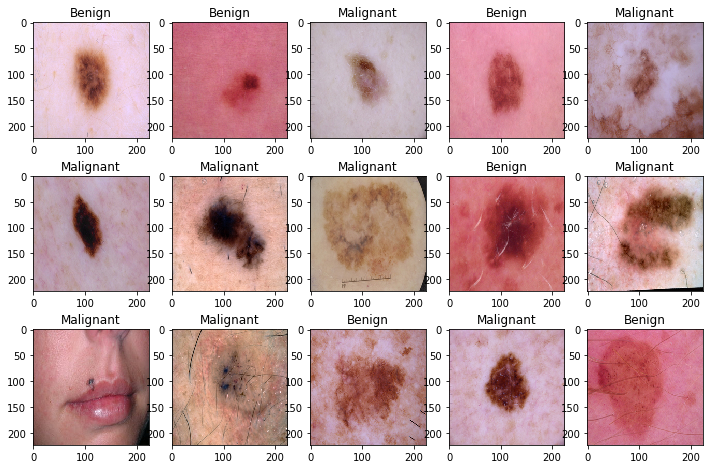

In [3]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X[i], interpolation='nearest')
plt.show()

# Step 3: Categorical Labels
Turn labels into one hot encoding

In [4]:
y = to_categorical(y, num_classes= 2)

# Step 4 : Normalization
Normalize all Values of the pictures by dividing all the RGB values by 255

In [5]:
# With data augmentation to prevent overfitting 
X_scaled = X/255

# Step 5 : Train Test Split
In this step we have splitted the dataset into training and testing set of 80:20 ratio

In [6]:
X_train, X_test, y_train, y_test= train_test_split(X_scaled, 
                                                 y,
                                                 test_size=0.20,
                                                 random_state=42)

# Step 6: Autoencoder


In [22]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(224, 224, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 112, 112, 8)       1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 56, 56, 8)         584       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 8)         0         
__________

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Instructions for updating:
Use tf.cast instead.
Train on 2637 samples, validate on 660 samples
Epoch 1/50


ValueError: Error when checking input: expected input_1 to have 2 dimensions, but got array with shape (660, 224, 224, 3)

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")